In [1]:
from common.common_imports import *
from common.util import *
from data.dataloader import *
from transformer import *
from run_model import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
torch.cuda.empty_cache()

cuda


In [3]:
# RUN SETTINGS
row_len = 8 # aka num_feats, aka d_model
max_src_window = 1000
test_size = 20
num_epochs = 1
batch_size = 1
num_workers = 0
days_pred_list = [5]

# MODEL PARAMS
num_heads=4
num_encoder_layers=4
num_decoder_layers=4
dropout=0.1

# OPTIM PARAMS
lr = 0.4
max_norm = 100000

In [4]:
# DATALOADER
train_loader, test_loader = create_splits(
    batch_size=batch_size,
    test_size=test_size,
    num_workers=num_workers
)

In [5]:
# MODEL
model = stonks_transformer_model(
    d_model=row_len,
    nhead=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout=dropout,
    device=device
)

In [6]:
# BATCH PROCESSORTrue
batch_processor = BatchProcessor(max_src_window)

  0%|          | 0/4613 [00:00<?, ?it/s]

bad loss
bad loss
 
-2.001e-05 x + 5.534
Avg Loss: 339887.9555608365


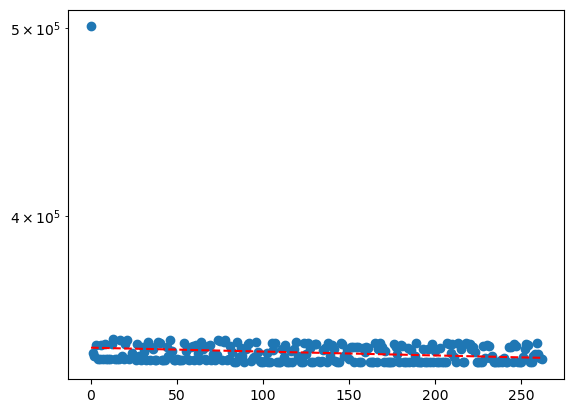

In [7]:
y = train_stonks_transformer(
    model=model,
    learning_rate=lr,
    max_norm=max_norm,
    days_pred_list=days_pred_list,
    train_loader=train_loader,
    num_epochs=num_epochs,
    batch_processor=batch_processor,
    device=device
)
plot_loss(y)
print("Avg Loss:", np.mean(y))
#e1,bs1,lr0.5 = -2.001e-05x, 339887

In [8]:
y = test_stonks_transformer(
    model=model,
    days_pred=test_size,
    test_loader=test_loader,
    batch_processor=batch_processor,
    device=device
)
print("Avg Loss:", np.mean(y))

  0%|          | 0/4613 [00:00<?, ?it/s]

Avg Loss: 344043.8637015782
